In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

import requests
from io import StringIO as sio

import baltic as bt

address='https://raw.githubusercontent.com/nicfel/Reassortment-Material/master/Applications/InfB/combined/infB_sub3.summary.trees' ## where the tree we'll use lives

fetch_tree = requests.get(address) ## fetch tree
treeFile=sio(fetch_tree.text) ## stream from repo copy

ll=bt.loadNexus(treeFile) ## treeFile here can alternatively be a path to a local file

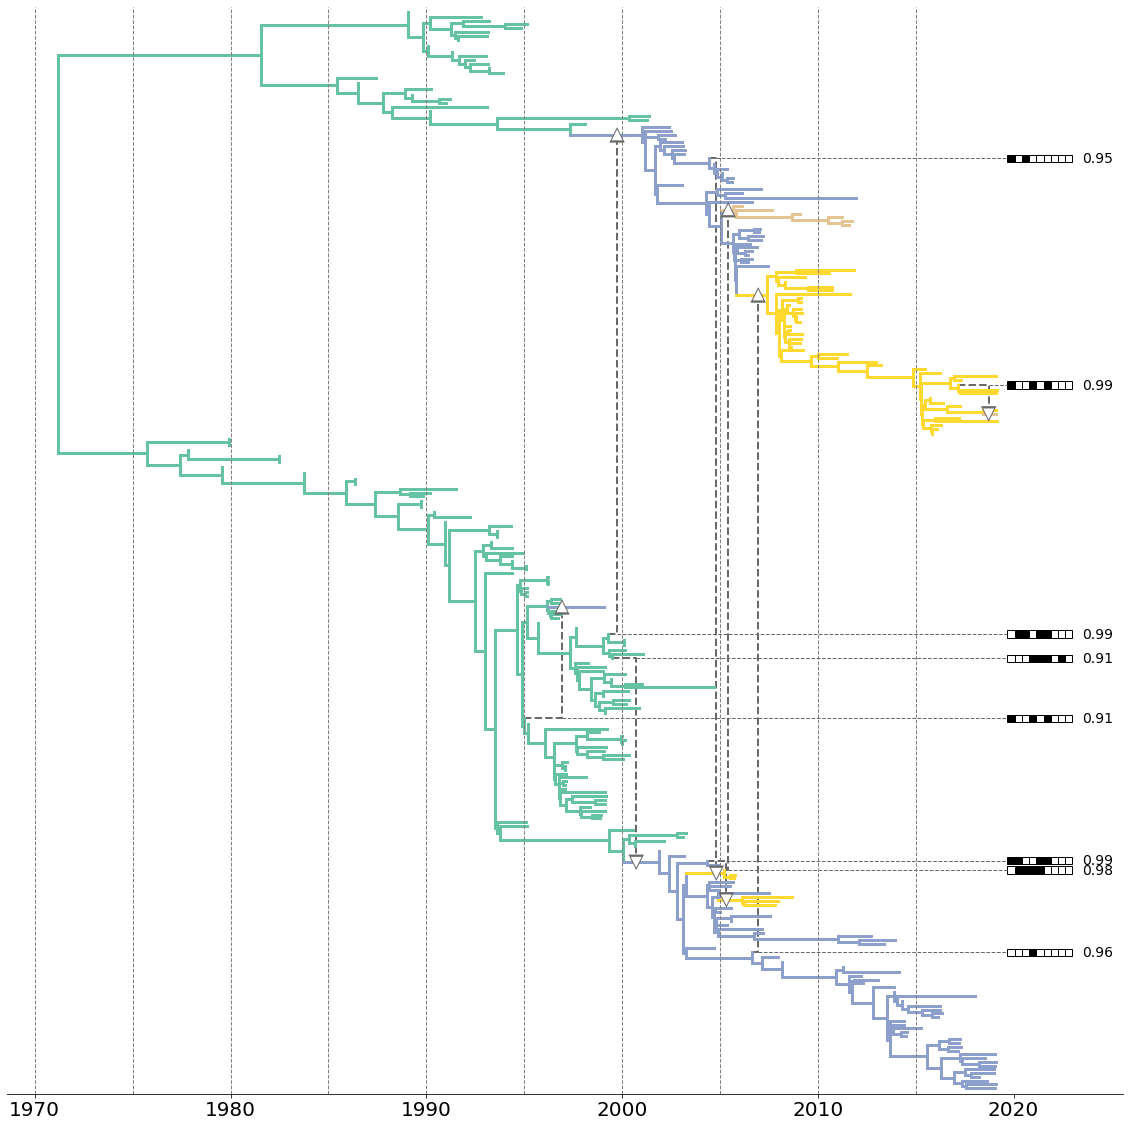

In [2]:
fig = plt.figure(figsize=(20, 20),facecolor='w') ## create figure
gs = gridspec.GridSpec(1,1,wspace=0.0) ## using gridspec by default
ax=plt.subplot(gs[0],facecolor='w') ## create axes

posteriorCutoff=lambda k: k.traits['posterior']>=0.9 ## define cutoff for removing reassortment events (current summary procedure is quite generous)
keep=set(list(filter(posteriorCutoff,ll.getBranches(lambda k: isinstance(k,bt.reticulation))))+ll.getExternal(lambda k: isinstance(k,bt.leaf))) ## remove reassortment at a given cutoff

colour_cycle=[mpl.cm.Set2(i) for i in [0.1,0.3,0.7,0.8]] ## define a list of colours to cycle between upon reassortment

for k in ll.Objects:
    k.traits['re']=0 ## define a new trait for number of reassortments

for k in sorted(ll.Objects,key=lambda w: w.height): ## iterate through branches, starting with oldest ones
    if hasattr(k,'contribution'): ## if branch is the result of reassortment
        subtree=ll.traverse_tree(k,include_condition=lambda w:True) ## traverse the subtree, remembering every branch visited along the way
        for w in subtree: ## for every branch in subtree
            if posteriorCutoff(k.contribution): ## if it's a branch that passes a posterior threshold
                w.traits['re']=max([w.traits['re']+1,k.contribution.traits['re']+1]) ## increment on maximum reassortment number up to this point (increment either parent's or contribution's statistic)


target=lambda k: isinstance(k,bt.reticulation)==False ## don't draw reticulatation events (they behave like tips)
colour=lambda k: colour_cycle[k.traits['re']%len(colour_cycle)] ## get colour out of colour cycle

ll.plotTree(ax,target=target,x_attr=lambda k: k.absoluteTime,colour=colour,width=3) ## plot tree

segments=[seg for seg in ll.root.traits if 'seg' in seg and 'segsCarried' not in seg] ## get number of segments in tree

mostRecentTip=max(ll.getParameter('absoluteTime',use_trait=False)) ## most recent tip in tree

for k in ll.Objects: ## iterate over all branches
    if isinstance(k,bt.reticulation) and posteriorCutoff(k): ## dealing with reassortant branch
        segs=sorted(map(int,k.traits['segments'])) ## get travelling segment(s)
        c='dimgrey' ## colour for reticulation events
        size=120 ## size of triangles for reticulation events
        xp=k.parent.absoluteTime ## parental time
        x=k.absoluteTime ## current branch time
        y=k.y ## current branch y position
        
        reassorting=', '.join(map(str,segs)) ## comma separated list of reassorting segments
        w=0.37 ## width of box
        h=2 ## height of box
        
        ax.plot([x,mostRecentTip+0.5],[y,y],ls='--',color=c,lw=1) ## dotted line from reassorting lineage to end of tree
        
        ax.text(mostRecentTip+len(segments)*w+1,y,'%.2f'%(k.traits['posterior']),size=14,color='k',ha='left',va='center') ## add text to reassortment boxes indicating posterior probability
        
        for s in range(len(segments)): ## iterate over segments
            fc='k' if s in segs else 'w' ## box colour black if segment is reassorting, white otherwise
            seg=segments[s] ## get segment name
            base=mostRecentTip+0.5 ## where reassortment indicator boxes begin

            rect=plt.Rectangle((base+s*w,y-h/2),w,h,facecolor=fc,edgecolor='k',lw=1,clip_on=False) ## indicator rectangle for segment's reassortment
            ax.add_patch(rect) ## add rectangle to plot
            
        ax.plot([xp,x,x],[y,y,k.target.y],color=c,lw=2,ls='--',zorder=1) ## plot vertical lineage leaving donor and heading to recipient
        
        if k.target.y>k.y: ## triangle points up if reassortment donor below recipient
            marker='^'
        elif k.target.y<k.y: ## triangle points down if reassortment donor above recipient
            marker='v'
            
        ax.scatter(x,k.target.y,s=size,marker=marker,facecolor='w',edgecolor='none',zorder=300) ## plot triangle
        ax.scatter(x,k.target.y,s=size*2,marker=marker,facecolor=c,edgecolor='none',zorder=299) ## plot outline
    
[ax.spines[loc].set_visible(False) for loc in ['top','right','left']] ## no spines
[ax.axvline(t,ls='--',lw=1,color='grey') for t in range(1970,2020,5)] ## add time lines
ax.set_yticks([]) ## no y ticks
ax.set_yticklabels([])

ax.tick_params(labelsize=20)
ax.set_ylim(-1,ll.ySpan+1)

plt.show()